In [1]:
import kagglehub


path = kagglehub.dataset_download("tawsifurrahman/covid19-radiography-database")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/covid19-radiography-database


In [2]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0

2025-04-20 11:43:16.002174: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745149396.203565      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745149396.261608      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
else:
    print("No GPU devices found.")

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

dataset_path = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset'
image_size = (224, 224)
batch_size = 64

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3
)

train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 29632 images belonging to 4 classes.
Found 12698 images belonging to 4 classes.


In [5]:
validation_generator

In [6]:
def build_model(base_model):
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dense(512, activation='relu')(x)
    output = layers.Dense(train_generator.num_classes, activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=output)
    return model

In [7]:
def train_model(model, train_gen, val_gen, freeze_until=None):
    if freeze_until is not None:
        for layer in model.layers[:freeze_until]:
            layer.trainable = False
    else:
        for layer in model.layers:
            layer.trainable = True
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    start = time.time()
    history = model.fit(train_gen, validation_data=val_gen, epochs=20, batch_size=batch_size)
    end = time.time()
    duration = end - start
    return history, duration

In [8]:
def evaluate_model(model, val_gen):
    val_gen.reset()
    preds = model.predict(val_gen)
    y_pred = np.argmax(preds, axis=1)
    y_true = val_gen.classes
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred, target_names=list(val_gen.class_indices.keys())))
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, prec, rec, f1

In [9]:
def plot_history(history, title):
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title(f'{title} - Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title(f'{title} - Accuracy')
    plt.legend()
    plt.show()

In [10]:
from tensorflow.keras.utils import plot_model

def describe_model(model, plot=False, plot_path="model_architecture.png"):
    print("📄 Model Summary:\n")
    model.summary()
    
    total_params = model.count_params()
    trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])
    non_trainable_params = np.sum([np.prod(v.shape) for v in model.non_trainable_weights])

    print("\n🔢 Model Parameters:")
    print(f"Total parameters       : {total_params:,}")
    print(f"Trainable parameters   : {trainable_params:,}")
    print(f"Non-trainable parameters: {non_trainable_params:,}")

    if plot:
        try:
            plot_model(model, show_shapes=True, show_layer_names=True, to_file=plot_path)
            print(f"\n🖼️ Model architecture saved to '{plot_path}'")
        except Exception as e:
            print(f"\n⚠️ Could not plot model: {e}")

I0000 00:00:1745149466.113773      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745149487.739909      73 service.cc:148] XLA service 0x7ab814211a30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745149487.740722      73 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745149488.670690      73 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/463 ━━━━━━━━━━━━━━━━━━━━ 2:41:34 21s/step - accuracy: 0.3281 - loss: 1.4539

I0000 00:00:1745149492.928398      73 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


463/463 ━━━━━━━━━━━━━━━━━━━━ 448s 925ms/step - accuracy: 0.6670 - loss: 0.9155 - val_accuracy: 0.8528 - val_loss: 0.3999
Epoch 2/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 146s 314ms/step - accuracy: 0.7640 - loss: 0.5971 - val_accuracy: 0.8643 - val_loss: 0.3701
Epoch 3/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 137s 292ms/step - accuracy: 0.7746 - loss: 0.5631 - val_accuracy: 0.8634 - val_loss: 0.3809
Epoch 4/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 135s 288ms/step - accuracy: 0.7909 - loss: 0.5365 - val_accuracy: 0.8635 - val_loss: 0.3730
Epoch 5/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 136s 291ms/step - accuracy: 0.7919 - loss: 0.5201 - val_accuracy: 0.8458 - val_loss: 0.4682
Epoch 6/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 133s 285ms/step - accuracy: 0.8076 - loss: 0.4960 - val_accuracy: 0.8608 - val_loss: 0.4173
Epoch 7/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 134s 288ms/step - accuracy: 0.8005 - loss: 0.4988 - val_accuracy: 0.8642 - val_loss: 0.4105
Epoch 8/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 135s 290ms/step - accuracy: 0.8122 - loss: 0.46

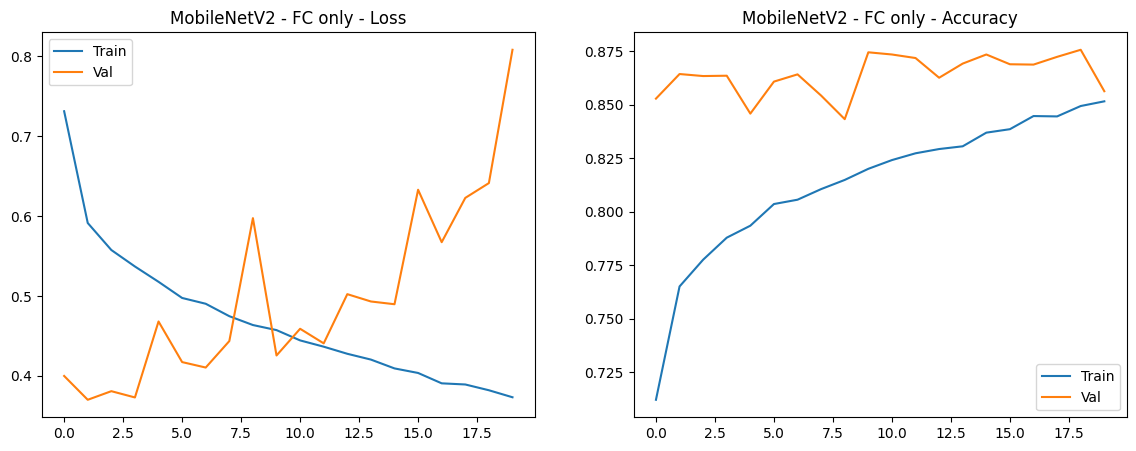

199/199 ━━━━━━━━━━━━━━━━━━━━ 54s 253ms/step
[[ 327  683 1032  127]
 [ 561 1156 1728  162]
 [ 976 1966 2864  309]
 [ 131  260  378   38]]
                 precision    recall  f1-score   support

          COVID       0.16      0.15      0.16      2169
   Lung_Opacity       0.28      0.32      0.30      3607
         Normal       0.48      0.47      0.47      6115
Viral Pneumonia       0.06      0.05      0.05       807

       accuracy                           0.35     12698
      macro avg       0.25      0.25      0.25     12698
   weighted avg       0.34      0.35      0.34     12698

📄 Model Summary:



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 7,773,774 (29.65 MB)

 Trainable params: 1,838,596 (7.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 3,677,194 (14.03 MB)


🔢 Model Parameters:
Total parameters       : 4,096,580
Trainable parameters   : 1,838,596
Non-trainable parameters: 2,257,984


In [11]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = build_model(base_model)
history, duration = train_model(model, train_generator, validation_generator, freeze_until=len(base_model.layers))
plot_history(history, 'MobileNetV2 - FC only')
evaluate_model(model, validation_generator)
describe_model(model)

Epoch 1/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 147s 294ms/step - accuracy: 0.6492 - loss: 0.9538 - val_accuracy: 0.8334 - val_loss: 0.4313
Epoch 2/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 133s 284ms/step - accuracy: 0.7587 - loss: 0.6059 - val_accuracy: 0.8401 - val_loss: 0.4252
Epoch 3/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 133s 284ms/step - accuracy: 0.7732 - loss: 0.5646 - val_accuracy: 0.8663 - val_loss: 0.3606
Epoch 4/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 132s 284ms/step - accuracy: 0.7829 - loss: 0.5389 - val_accuracy: 0.8738 - val_loss: 0.3449
Epoch 5/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 133s 285ms/step - accuracy: 0.8020 - loss: 0.5070 - val_accuracy: 0.8603 - val_loss: 0.4119
Epoch 6/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 133s 284ms/step - accuracy: 0.8064 - loss: 0.4916 - val_accuracy: 0.8660 - val_loss: 0.3864
Epoch 7/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 136s 291ms/step - accuracy: 0.8072 - loss: 0.4834 - val_accuracy: 0.8749 - val_loss: 0.3840
Epoch 8/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 136s 291ms/step - accuracy: 0.8131 -

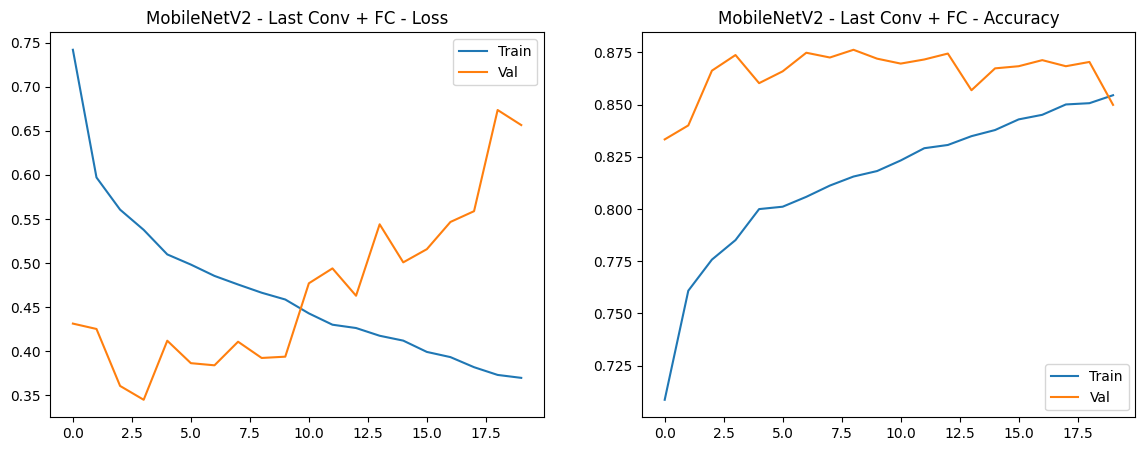

199/199 ━━━━━━━━━━━━━━━━━━━━ 55s 258ms/step
[[ 324  626 1097  122]
 [ 431 1013 1953  210]
 [ 820 1727 3251  317]
 [ 100  221  451   35]]
                 precision    recall  f1-score   support

          COVID       0.19      0.15      0.17      2169
   Lung_Opacity       0.28      0.28      0.28      3607
         Normal       0.48      0.53      0.51      6115
Viral Pneumonia       0.05      0.04      0.05       807

       accuracy                           0.36     12698
      macro avg       0.25      0.25      0.25     12698
   weighted avg       0.35      0.36      0.36     12698

📄 Model Summary:



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 7,773,774 (29.65 MB)

 Trainable params: 1,838,596 (7.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 3,677,194 (14.03 MB)


🔢 Model Parameters:
Total parameters       : 4,096,580
Trainable parameters   : 1,838,596
Non-trainable parameters: 2,257,984


In [12]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model2 = build_model(base_model)
history2, duration = train_model(model2, train_generator, validation_generator, freeze_until=-5)
plot_history(history2, 'MobileNetV2 - Last Conv + FC')
evaluate_model(model2, validation_generator)
describe_model(model2)

Epoch 1/20


E0000 00:00:1745155393.976458      71 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745155394.174159      71 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


463/463 ━━━━━━━━━━━━━━━━━━━━ 216s 345ms/step - accuracy: 0.6854 - loss: 0.8126 - val_accuracy: 0.6659 - val_loss: 3.9736
Epoch 2/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 157s 337ms/step - accuracy: 0.7866 - loss: 0.5462 - val_accuracy: 0.4967 - val_loss: 4.4823
Epoch 3/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 147s 313ms/step - accuracy: 0.8103 - loss: 0.4936 - val_accuracy: 0.5635 - val_loss: 2.7191
Epoch 4/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 142s 303ms/step - accuracy: 0.8175 - loss: 0.4725 - val_accuracy: 0.4869 - val_loss: 5.4560
Epoch 5/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 140s 300ms/step - accuracy: 0.8249 - loss: 0.4435 - val_accuracy: 0.5009 - val_loss: 5.8058
Epoch 6/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 144s 307ms/step - accuracy: 0.8323 - loss: 0.4343 - val_accuracy: 0.6519 - val_loss: 2.6824
Epoch 7/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 145s 311ms/step - accuracy: 0.8420 - loss: 0.4116 - val_accuracy: 0.6565 - val_loss: 1.9446
Epoch 8/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 142s 303ms/step - accuracy: 0.8464 - loss: 0.39

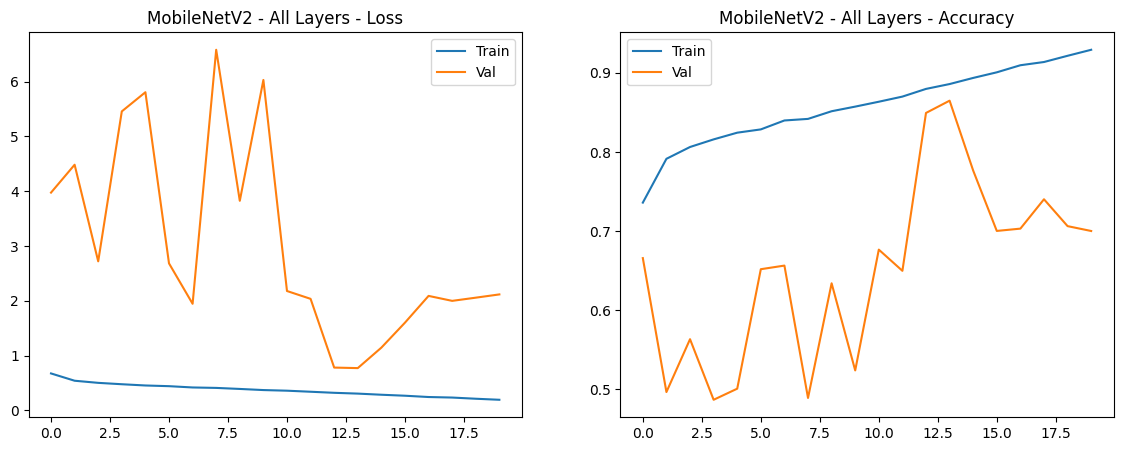

199/199 ━━━━━━━━━━━━━━━━━━━━ 53s 251ms/step
[[ 113  496 1532   28]
 [ 159  742 2651   55]
 [ 306 1240 4491   78]
 [  44  191  560   12]]
                 precision    recall  f1-score   support

          COVID       0.18      0.05      0.08      2169
   Lung_Opacity       0.28      0.21      0.24      3607
         Normal       0.49      0.73      0.59      6115
Viral Pneumonia       0.07      0.01      0.02       807

       accuracy                           0.42     12698
      macro avg       0.25      0.25      0.23     12698
   weighted avg       0.35      0.42      0.36     12698

📄 Model Summary:



Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 12,221,518 (46.62 MB)

 Trainable params: 4,062,468 (15.50 MB)

 Non-trainable params: 34,112 (133.25 KB)

 Optimizer params: 8,124,938 (30.99 MB)


🔢 Model Parameters:
Total parameters       : 4,096,580
Trainable parameters   : 4,062,468
Non-trainable parameters: 34,112


In [13]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model3 = build_model(base_model)
history3, duration = train_model(model3, train_generator, validation_generator, freeze_until=None)
plot_history(history3, 'MobileNetV2 - All Layers')
evaluate_model(model3, validation_generator)
describe_model(model3)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 174s 319ms/step - accuracy: 0.4763 - loss: 1.2019 - val_accuracy: 0.4816 - val_loss: 1.1886
Epoch 2/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 135s 289ms/step - accuracy: 0.4789 - loss: 1.1916 - val_accuracy: 0.4816 - val_loss: 1.1886
Epoch 3/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 134s 287ms/step - accuracy: 0.4775 - loss: 1.1934 - val_accuracy: 0.4816 - val_loss: 1.1865
Epoch 4/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 137s 292ms/step - accuracy: 0.4884 - loss: 1.1796 - val_accuracy: 0.4816 - val_loss: 1.1866
Epoch 5/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 138s 296ms/step - accuracy: 0.4818 - loss: 1.1890 - val_accuracy: 0.4816 - val_loss: 1.1867
Epoch 6/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 139s 297ms/step - accuracy: 0.4798 - loss: 1.1910 - val_accuracy: 0.4816 - val_loss: 1.1880
Epoch 7/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 143s 307ms/step - accuracy: 0.4829 - loss: 1.1832 - val_accuracy: 0.4816 - val_loss: 1.1891
Epoch 8/20
463/463 ━━━━━━

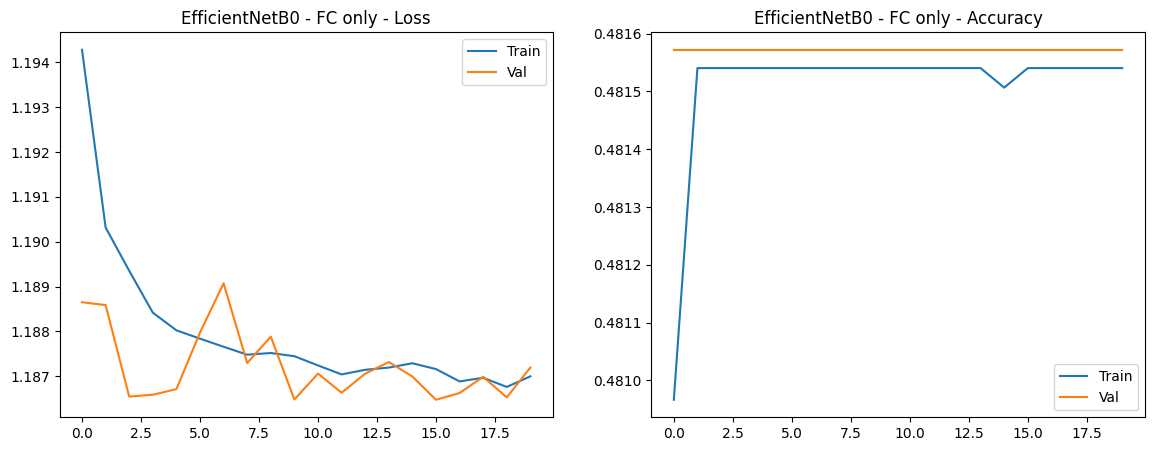

199/199 ━━━━━━━━━━━━━━━━━━━━ 60s 266ms/step
[[   0    0 2169    0]
 [   0    0 3607    0]
 [   0    0 6115    0]
 [   0    0  807    0]]
                 precision    recall  f1-score   support

          COVID       0.00      0.00      0.00      2169
   Lung_Opacity       0.00      0.00      0.00      3607
         Normal       0.48      1.00      0.65      6115
Viral Pneumonia       0.00      0.00      0.00       807

       accuracy                           0.48     12698
      macro avg       0.12      0.25      0.16     12698
   weighted avg       0.23      0.48      0.31     12698

📄 Model Summary:



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classif

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 9,565,361 (36.49 MB)

 Trainable params: 1,838,596 (7.01 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 3,677,194 (14.03 MB)


🔢 Model Parameters:
Total parameters       : 5,888,167
Trainable parameters   : 1,838,596
Non-trainable parameters: 4,049,571.0


In [14]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model4 = build_model(base_model)
history4, duration = train_model(model4, train_generator, validation_generator, freeze_until=len(base_model.layers))
plot_history(history4, 'EfficientNetB0 - FC only')
evaluate_model(model4, validation_generator)
describe_model(model4)

Epoch 1/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 166s 308ms/step - accuracy: 0.4780 - loss: 1.1915 - val_accuracy: 0.4816 - val_loss: 1.1873
Epoch 2/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 138s 294ms/step - accuracy: 0.4807 - loss: 1.1904 - val_accuracy: 0.4816 - val_loss: 1.1940
Epoch 3/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 137s 294ms/step - accuracy: 0.4829 - loss: 1.1858 - val_accuracy: 0.4816 - val_loss: 1.1868
Epoch 4/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 139s 298ms/step - accuracy: 0.4818 - loss: 1.1863 - val_accuracy: 0.4816 - val_loss: 1.1866
Epoch 5/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 136s 290ms/step - accuracy: 0.4811 - loss: 1.1882 - val_accuracy: 0.4816 - val_loss: 1.1875
Epoch 6/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 135s 290ms/step - accuracy: 0.4773 - loss: 1.1905 - val_accuracy: 0.4816 - val_loss: 1.1866
Epoch 7/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 134s 286ms/step - accuracy: 0.4850 - loss: 1.1847 - val_accuracy: 0.4816 - val_loss: 1.1875
Epoch 8/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 134s 286ms/step - accuracy: 0.4827 -

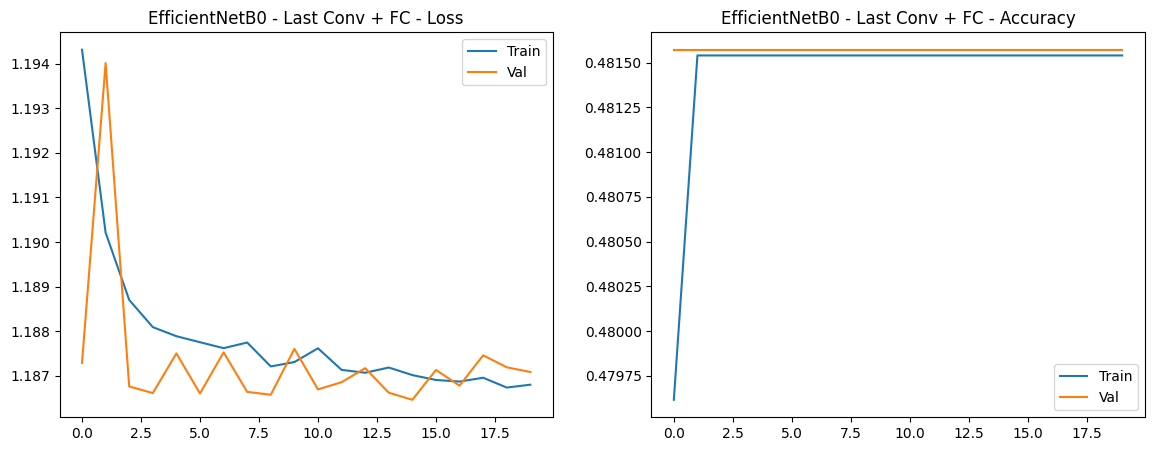

199/199 ━━━━━━━━━━━━━━━━━━━━ 57s 258ms/step
[[   0    0 2169    0]
 [   0    0 3607    0]
 [   0    0 6115    0]
 [   0    0  807    0]]
                 precision    recall  f1-score   support

          COVID       0.00      0.00      0.00      2169
   Lung_Opacity       0.00      0.00      0.00      3607
         Normal       0.48      1.00      0.65      6115
Viral Pneumonia       0.00      0.00      0.00       807

       accuracy                           0.48     12698
      macro avg       0.12      0.25      0.16     12698
   weighted avg       0.23      0.48      0.31     12698

📄 Model Summary:



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classif

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 224, 224, 3)    │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 9,565,361 (36.49 MB)

 Trainable params: 1,838,596 (7.01 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 3,677,194 (14.03 MB)


🔢 Model Parameters:
Total parameters       : 5,888,167
Trainable parameters   : 1,838,596
Non-trainable parameters: 4,049,571.0


In [15]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model5 = build_model(base_model)
history5, duration = train_model(model5, train_generator, validation_generator, freeze_until=-5)
plot_history(history5, 'EfficientNetB0 - Last Conv + FC')
evaluate_model(model5, validation_generator)
describe_model(model5)

Epoch 1/20


E0000 00:00:1745164004.934685      73 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745164005.128577      73 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745164005.682284      73 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745164005.889321      73 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745164006.284031      73 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

463/463 ━━━━━━━━━━━━━━━━━━━━ 238s 334ms/step - accuracy: 0.7045 - loss: 0.7324 - val_accuracy: 0.2859 - val_loss: 2.5637
Epoch 2/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 142s 304ms/step - accuracy: 0.8029 - loss: 0.5131 - val_accuracy: 0.8681 - val_loss: 0.3783
Epoch 3/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 141s 301ms/step - accuracy: 0.8262 - loss: 0.4613 - val_accuracy: 0.9148 - val_loss: 0.2463
Epoch 4/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 142s 303ms/step - accuracy: 0.8349 - loss: 0.4265 - val_accuracy: 0.9151 - val_loss: 0.2537
Epoch 5/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 143s 305ms/step - accuracy: 0.8465 - loss: 0.3991 - val_accuracy: 0.8848 - val_loss: 0.3203
Epoch 6/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 141s 302ms/step - accuracy: 0.8620 - loss: 0.3640 - val_accuracy: 0.9378 - val_loss: 0.1992
Epoch 7/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 142s 304ms/step - accuracy: 0.8753 - loss: 0.3354 - val_accuracy: 0.8714 - val_loss: 0.3990
Epoch 8/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 142s 303ms/step - accuracy: 0.8869 - loss: 0.29

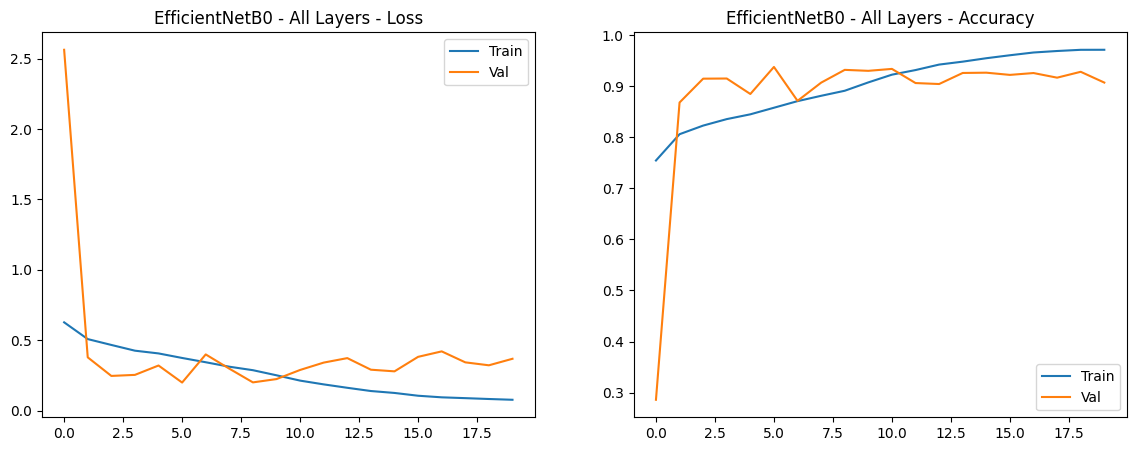

199/199 ━━━━━━━━━━━━━━━━━━━━ 58s 262ms/step
[[ 322  711  977  159]
 [ 619 1203 1549  236]
 [1011 2064 2673  367]
 [ 155  265  342   45]]
                 precision    recall  f1-score   support

          COVID       0.15      0.15      0.15      2169
   Lung_Opacity       0.28      0.33      0.31      3607
         Normal       0.48      0.44      0.46      6115
Viral Pneumonia       0.06      0.06      0.06       807

       accuracy                           0.33     12698
      macro avg       0.24      0.24      0.24     12698
   weighted avg       0.34      0.33      0.34     12698

📄 Model Summary:



Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_4 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_2           │ (None, 224, 224, 3)    │              7 │ rescaling_4[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_5 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_5[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 17,580,457 (67.06 MB)

 Trainable params: 5,846,144 (22.30 MB)

 Non-trainable params: 42,023 (164.16 KB)

 Optimizer params: 11,692,290 (44.60 MB)


🔢 Model Parameters:
Total parameters       : 5,888,167
Trainable parameters   : 5,846,144
Non-trainable parameters: 42,023.0


In [16]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model6 = build_model(base_model)
history6, duration = train_model(model6, train_generator, validation_generator, freeze_until=None)
plot_history(history6, 'EfficientNetB0 - All Layers')
evaluate_model(model6, validation_generator)
describe_model(model6)